# K-Means Clustering

In this repository we will attempt to cluster Rice Bikes transactions according to their repairs

## 0. Imports and Data 

In [22]:
import random

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm

In [23]:
df = pd.read_csv("../../data/rb_tx_data.csv")
df = df.set_index("TransactionID")

df = df.replace(np.nan,0)

df = df.loc[(df['TotalCost']>0) & 
            (df['RepairCost']>0) &
            (df['TurnaroundTime']>0) &
            (df['TurnaroundTime']<38) 
            ]

X = df.loc[:, df.columns[14:] ].values
y = df.TurnaroundTime.values.reshape(-1,1)

## 1. Implementation

In [24]:
def random_centroids(X, k):
    """
    Generate k random centroids from the given feature data
    """
    # indices of k random rows of X
    random_idxs = random.sample(range(len(X)), k)
    
    return X[random_idxs]

In [25]:
def assign_cluster(X, centroids):
    """
    Given feature data and a set of clusters, return a list of assignments
    where assignments_i is the index of the closet centroid to xi
    """
    assignments = np.empty(X.shape[0], dtype=np.int8)
    for i, xi in enumerate(X):
        cluster_distances = []

        for centroid in centroids:
            d_cluster = np.linalg.norm(xi - centroid)
            cluster_distances.append(d_cluster)

        assignment = np.argmin(cluster_distances)
        assignments[i] = assignment

    return assignments


In [26]:
def update_centroids(X, centroids, assignments):
    """
    Compute the new centroid of each cluster by 
    averaging all samples grouped by assignment
    """
    new_centroids = np.empty_like(centroids)

    for i in range(len(centroids)):
        # get all samples assigned to the current cluseter
        X_cluster_i = X[np.argwhere(assignments == i)]

        centroid = np.mean(X_cluster_i, axis= 0)
        new_centroids[i] = centroid

    return new_centroids




In [27]:
def sum_squared_error(X, centroids, assignments):
    """
    Calculate the sum of squared errors between each sample and its assigned centroid
    """

    diff = X - centroids[assignments]

    return np.sum(diff * diff)

In [29]:
def kmeans_clustering(X, k, max_iter = 100, tol=1e-8):
    #i = -1
    centroids = random_centroids(X, k)

    scaler = StandardScaler()

    X = scaler.fit_transform(X)
    sse_history = []
    

    for i in tqdm(range(max_iter)):
        
        assignments = assign_cluster(X, centroids)
        centroids = update_centroids(X, centroids, assignments)
        sse_i = sum_squared_error(X, centroids, assignments)
        sse_history.append(sse_i)


        if (len(sse_history) >1 and abs(sse_history[i] - sse_history[i -1])/sse_history[i -1]  < tol):
            print("Stopping early, tolerance met")
            break


    return assignments, scaler.inverse_transform(centroids), sse_history


## 3. Execution and Evaluation

In [30]:
assignments, centroids, sse_history = kmeans_clustering(X, k=3)

  9%|▉         | 9/100 [00:00<00:03, 23.27it/s]

Stopping early, tolerance met


Text(0, 0.5, 'SSE')

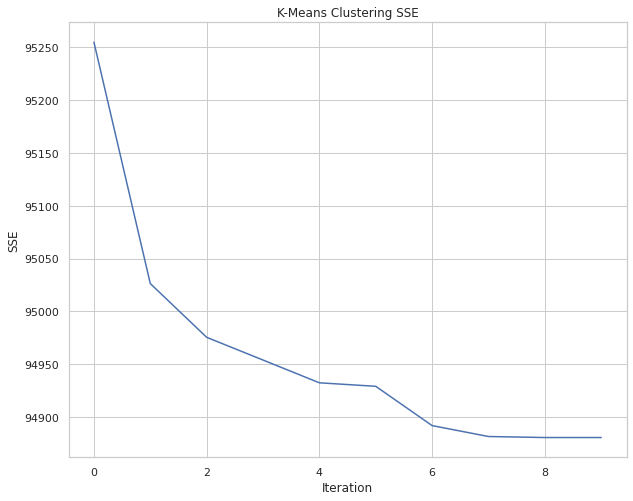

In [31]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
plt.plot(range(len(sse_history)), sse_history)
plt.title("K-Means Clustering SSE")
plt.xlabel("Iteration")
plt.ylabel("SSE")

In [32]:
repairs = df.columns[14:].values

cluster_counts = np.unique(assignments, return_counts=True)[1]

top_repair_count = 5

for i, centroid in enumerate(centroids):
    top_idxs = np.argsort(centroid)[-top_repair_count:]
    top_repairs = repairs[top_idxs]


    print(f"{20*'-'} Cluster {i} (n = {cluster_counts [i]}) {20*'-'}")

    for i in range(top_repair_count-1, -1, -1):
        print("\t{:<30}{:<8.4g}".format(
            top_repairs[i],
            centroid[top_idxs[i]]
        ))


-------------------- Cluster 0 (n = 1102) --------------------
	RearFlatRepair                0.3294  
	MinorAdjustment               0.2169  
	FrontFlatRepair               0.1751  
	AdjustRimBrake                0.08621 
	CleanAndLubeChain             0.07078 
-------------------- Cluster 1 (n = 374) --------------------
	ReplaceChain                  0.5722  
	AdjustRimBrake                0.4492  
	InstallBrakePads              0.1925  
	AdjustRearDerailleur          0.1872  
	MinorAdjustment               0.1818  
-------------------- Cluster 2 (n = 168) --------------------
	AdjustRimBrake                0.5357  
	RearWheelTrue                 0.5119  
	FrontWheelTrue                0.4048  
	ReplaceChain                  0.2679  
	AdjustHubBearings(Rear)       0.25    


Notably, the cluster 0 has high counts of both front and rear flat repairs as well as minor adjustments, which are all relatively low cost repairs which are typically performed outpatient.  

Cluster 1 appears to have captured what I might call "intermediate" repairs such as chain replaces, rim brake adjustments / pad replacements, and derailleur adjusts. These can be completed inpatient or outpatient depending on the customer needs or shop environment at the time

Finally cluster 2 has captured many repairs with both front and rear wheel trues as well as bearing adjustments. These are all advanced repairs that are almost exclusively done inpatient, and reflects a significant departure from the involvement of repairs of the prior clusters

In [33]:
def assignments_by_cluster(assignments, centroids):
    """
    Return a list a tuples of the form (cluster, indexes_of_samples_in_cluster)
    """
    return [(i, np.argwhere(assignments == i)) for i in range(len(centroids))] 

In [35]:
for cluster, cluster_idxs in assignments_by_cluster(assignments, centroids):
    print(f"Average repair costs for cluster {cluster}: {np.mean(y[cluster_idxs])}")

Average repair costs for cluster 0: 2.9862550340794516
Average repair costs for cluster 1: 7.282316483363043
Average repair costs for cluster 2: 10.521603363095238


Our understanding of the distinction between these three clusters is well reflected in their average repair costs.